# Retail Demo Store - Personalization Workshop

Welcome to the Retail Demo Store Personalization Workshop. In this module we're going to be adding three core personalization features powered by [Amazon Personalize](https://aws.amazon.com/personalize/): related product recommendations on the product detail page, personalized recommendations on the Retail Demo Store homepage, and personalized ranking of items on the featured product page and product search results. This will allow us to give our users targeted recommendations based on their activity.

Recommended Time: 2 Hours

## Setup

To get started, we need to perform a bit of setup. Walk through each of the following steps to configure your environment to interact with the Amazon Personalize Service.

### Import Dependencies and Setup Boto3 Python Clients

Throughout this workshop we will need access to some common libraries and clients for connecting to AWS services. We also have to retrieve Uid from a SageMaker notebook instance tag.

In [1]:
# Import Dependencies

import boto3
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import csv
import sys
import botocore
import uuid

from packaging import version
from random import randint
from botocore.exceptions import ClientError

%matplotlib inline

# Setup Clients

personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
personalize_events = boto3.client('personalize-events')

servicediscovery = boto3.client('servicediscovery')
ssm = boto3.client('ssm')

with open('/opt/ml/metadata/resource-metadata.json') as f:
  data = json.load(f)
sagemaker = boto3.client('sagemaker')
sagemakerResponce = sagemaker.list_tags(ResourceArn=data["ResourceArn"])
for tag in sagemakerResponce["Tags"]:
    if tag['Key'] == 'Uid':
        Uid = tag['Value']
        break

### Configure Bucket and Data Output Location

We will be configuring some variables that will store the location of our source data. When the Retail Demo Store stack was deployed in this account, an S3 bucket was created for you and the name of this bucket was stored in Systems Manager Parameter Store. Using the Boto3 client we can get the name of this bucket for use within our Notebook.

In [2]:
response = ssm.get_parameter(
    Name='retaildemostore-stack-bucket'
)

bucket = response['Parameter']['Value']     # Do Not Change
items_filename = "items.csv"                # Do Not Change
users_filename = "users.csv"                # Do Not Change
interactions_filename = "interactions.csv"  # Do Not Change

print('Bucket: {}'.format(bucket))

Bucket: retaildemostore-base-1cicinqj7c4zo-bu-stackbucket-zvh2i50lngm9


## Get, Prepare, and Upload User, Product, and Interaction Data

Amazon Personalize provides predefined recipes, based on common use cases, for training models. A recipe is a machine learning algorithm that you use with settings, or hyperparameters, and the data you provide to train an Amazon Personalize model. The data you provide to train a model are organized into separate datasets by the type of data being provided. A collection of datasets are organized into a dataset group. The three dataset types supported by Personalize are items, users, and interactions. Depending on the recipe type you choose, a different combination of dataset types are required. For all recipe types, an interactions dataset is required. Interactions represent how users interact with items. For example, viewing a product, watching a video, listening to a recording, or reading an article. For this workshop, we will be using a recipe that supports all three dataset types.

When we deployed the Retail Demo Store, it was deployed with an initial seed of fictitious User and Product data. We will use this data to train three models, or solutions, in the Amazon Personalize service which will be used to serve product recommendations, related items,  and to rerank product lists for our users. The User and Product data can be accessed from the Retail Demo Store's [Users](https://github.com/aws-samples/retail-demo-store/tree/master/src/users) and [Products](https://github.com/aws-samples/retail-demo-store/tree/master/src/products) microservices, respectively. We will access our data through microservice data APIs, process the data, and upload them as CSVs to S3. Once our datasets are in S3, we can import them into the Amazon Personalize service.

Let's get started.

### Get Products Service Instance

We will be pulling our Product data from the [Products Service](https://github.com/aws-samples/retail-demo-store/tree/master/src/products) that was deployed in Amazon Elastic Container Service as part of the Retail Demo Store. To connect to this service we will use [AWS Cloud Map](https://aws.amazon.com/cloud-map/)'s Service Discovery to discover an instance of the Product Service running in ECS, and then connect directly to that service instances to access our data.

In [3]:
response = servicediscovery.discover_instances(
    NamespaceName='retaildemostore.local',
    ServiceName='products',
    MaxResults=1,
    HealthStatus='HEALTHY'
)

products_service_instance = response['Instances'][0]['Attributes']['AWS_INSTANCE_IPV4']
print('Products Service Instance IP: {}'.format(products_service_instance))

Products Service Instance IP: 10.215.20.174


#### Download and Explore the Products Dataset

In [4]:
response = requests.get('http://{}/products/all'.format(products_service_instance))
products = response.json()
products_df = pd.DataFrame(products)
pd.set_option('display.max_rows', 5)

products_df

,id,url,sk,name,category,style,description,price,image,featured,gender_affinity
0,36,http://d2syr0qoho6cqh.cloudfront.net/#/product/36,,Exercise Headphones,electronics,headphones,These stylishly red ear buds wrap securely aro...,19.99,5.jpg,true,NaN
1,49,http://d2syr0qoho6cqh.cloudfront.net/#/product/49,,Light Brown Leather Lace-Up Boot,footwear,boot,Sturdy enough for the outdoors yet stylish to ...,89.95,11.jpg,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
54,43,http://d2syr0qoho6cqh.cloudfront.net/#/product/43,,Beauty Mask,beauty,grooming,Remove dirt and revitalize skin with this blac...,9.99,9.jpg,NaN,NaN
55,14,http://d2syr0qoho6cqh.cloudfront.net/#/product/14,,Coffee Gift Package,housewares,consumable,Mug and Coffee gift set combination package.,39.99,2.jpg,NaN,NaN


#### Prepare and Upload Data

When training models in Amazon Personalize, we can provide meta data about our items. For this workshop we will add each product's category and style to the item dataset. The product's unique identifier is required. Then we will rename the columns in our dataset to match our schema (defined later) and those expected by Personalize. Finally, we will save our dataset as a CSV and copy it to our S3 bucket.

In [5]:
products_dataset_df = products_df[['id','category','style']]
products_dataset_df = products_dataset_df.rename(columns = {'id':'ITEM_ID','category':'CATEGORY','style':'STYLE'}) 

products_dataset_df.to_csv(items_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(items_filename).upload_file(items_filename)

### Get Users Service Instance

We will be pulling our User data from the [Users Service](https://github.com/aws-samples/retail-demo-store/tree/master/src/users) that is deployed as part of the Retail Demo Store. To connect to this service we will use Service Discovery to discover an instance of the User Service, and then connect directly to that service instance to access our data.

In [6]:
response = servicediscovery.discover_instances(
    NamespaceName='retaildemostore.local',
    ServiceName='users',
    MaxResults=1,
    HealthStatus='HEALTHY'
)

users_service_instance = response['Instances'][0]['Attributes']['AWS_INSTANCE_IPV4']
print('Users Service Instance IP: {}'.format(users_service_instance))

Users Service Instance IP: 10.215.10.190


#### Download and Explore the Users Dataset

In [7]:
response = requests.get('http://{}/users/all?count=10000'.format(users_service_instance))
users = response.json()
users_df = pd.DataFrame(users)
# Remove any users without a persona or gender (i.e. created in web UI)
users_df = users_df[(users_df['persona'].str.strip().astype(bool)) | (users_df['gender'].str.strip().astype(bool))]
pd.set_option('display.max_rows', 5)

users_df

,id,username,email,first_name,last_name,addresses,age,gender,persona
0,1,user1,nathan.smith@example.com,Nathan,Smith,"[{'first_name': 'Nathan', 'last_name': 'Smith'...",28,M,electronics_beauty_outdoors
1,2,user2,kevin.martinez@example.com,Kevin,Martinez,"[{'first_name': 'Kevin', 'last_name': 'Martine...",19,M,electronics_beauty_outdoors
...,...,...,...,...,...,...,...,...,...
5998,5999,user5999,paige.chase@example.com,Paige,Chase,"[{'first_name': 'Paige', 'last_name': 'Chase',...",68,F,footwear_outdoors_apparel
5999,6000,user6000,amber.roberson@example.com,Amber,Roberson,"[{'first_name': 'Amber', 'last_name': 'Roberso...",27,F,housewares_apparel_electronics


#### Prepare and Upload Data

Similar to the items dataset we created above, we can provide metadata on our users when training models in Personalize. For this workshop we will include each user's age and gender. As before, we will name the columns to match our schema, save the data as a CSV, and upload to our S3 bucket.

In [8]:
users_dataset_df = users_df[['id','age','gender']]
users_dataset_df = users_dataset_df.rename(columns = {'id':'USER_ID','age':'AGE','gender':'GENDER'}) 

users_dataset_df.to_csv(users_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(users_filename).upload_file(users_filename)

### Create User-Items Interactions Dataset

To mimic user behavior, we will be generating a new dataset that represents user interactions with items. To make the interactions more realistic, we will use the pre-defined shopper persona for each user to generate event types for products matching that persona. We will create events for viewing products, add products to a cart, checking out, and completing orders.

In [9]:
%%time

# Minimum number of interactions to generate
min_interactions = 500000

# Percentages of each event type to generate
product_added_percent = .08
cart_viewed_percent = .05
checkout_started_percent = .02
order_completed_percent = .01

# Count of interactions generated for each event type
product_viewed_count = 0
product_added_count = 0
cart_viewed_count = 0
checkout_started_count = 0
order_completed_count = 0

# How many days in the past (from now) to start generating interactions
days_back = 90

start_time = int(time.time())
next_timestamp = start_time - (days_back * 24 * 60 * 60)
seconds_increment = int((start_time - next_timestamp) / min_interactions)
next_update = start_time + 60

assert seconds_increment > 0, "Increase days_back or reduce min_interactions"

print('Minimum interactions to generate: {}'.format(min_interactions))
print('Days back: {}'.format(days_back))
print('Starting timestamp: {} ({})'.format(next_timestamp, time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(next_timestamp))))
print('Seconds increment: {}'.format(seconds_increment))

print("Generating interactions... (this may take a few minutes)")
interactions = 0

subsets_cache = {}

with open(interactions_filename, 'w') as outfile:
    f = csv.writer(outfile)
    f.writerow(["ITEM_ID", "USER_ID", "EVENT_TYPE", "TIMESTAMP"])

    while interactions < min_interactions:
        if (time.time() > next_update):
            rate = interactions / (time.time() - start_time)
            to_go = (min_interactions - interactions) / rate
            print('Generated {} interactions so far ({:0.2f} seconds to go)'.format(interactions, to_go))
            next_update += 60

        # Pick a random user
        user = users_df.sample().iloc[0]

        # Determine category affinity from user's persona
        persona = user['persona']
        preferred_categories = persona.split('_')

        # Select category based on weighted preference of category order.
        category = np.random.choice(preferred_categories, 1, p=[0.6, 0.25, 0.15])[0]

        gender = user['gender']

        # Check if subset data frame is already cached for category & gender
        prods_subset_df = subsets_cache.get(category + gender)
        if prods_subset_df is None:
            # Select products from selected category without gender affinity or that match user's gender
            prods_subset_df = products_df.loc[(products_df['category'] == category) & ((products_df['gender_affinity'] == gender) | (products_df['gender_affinity'].isnull()))]
            # Update cache
            subsets_cache[category + gender] = prods_subset_df

        # Pick a random product from gender filtered subset
        product = prods_subset_df.sample().iloc[0]

        this_timestamp = next_timestamp + randint(0, seconds_increment)

        f.writerow([product['id'],
                    user['id'], 
                    'ProductViewed',
                    this_timestamp])

        next_timestamp += seconds_increment
        product_viewed_count += 1
        interactions += 1

        if product_added_count < int(product_viewed_count * product_added_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            f.writerow([product['id'],
                        user['id'], 
                        'ProductAdded',
                        this_timestamp])
            interactions += 1
            product_added_count += 1

        if cart_viewed_count < int(product_viewed_count * cart_viewed_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            f.writerow([product['id'],
                        user['id'], 
                        'CartViewed',
                        this_timestamp])
            interactions += 1
            cart_viewed_count += 1

        if checkout_started_count < int(product_viewed_count * checkout_started_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            f.writerow([product['id'],
                        user['id'], 
                        'CheckoutStarted',
                        this_timestamp])
            interactions += 1
            checkout_started_count += 1

        if order_completed_count < int(product_viewed_count * order_completed_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            f.writerow([product['id'],
                        user['id'], 
                        'OrderCompleted',
                        this_timestamp])
            interactions += 1
            order_completed_count += 1
    
print("Done")
print("Total interactions: " + str(interactions))
print("Total product viewed: " + str(product_viewed_count))
print("Total product added: " + str(product_added_count))
print("Total cart viewed: " + str(cart_viewed_count))
print("Total checkout started: " + str(checkout_started_count))
print("Total order completed: " + str(order_completed_count))

Minimum interactions to generate: 500000
Days back: 90
Starting timestamp: 1592142033 (2020-06-14 13:40:33)
Seconds increment: 15
Generating interactions... (this may take a few minutes)
Generated 43138 interactions so far (635.44 seconds to go)
Generated 86326 interactions so far (575.04 seconds to go)
Generated 129459 interactions so far (515.20 seconds to go)
Generated 172593 interactions so far (455.28 seconds to go)
Generated 215840 interactions so far (394.96 seconds to go)
Generated 259033 interactions so far (334.89 seconds to go)
Generated 302191 interactions so far (274.93 seconds to go)
Generated 345375 interactions so far (214.90 seconds to go)
Generated 388660 interactions so far (154.69 seconds to go)
Generated 431764 interactions so far (94.82 seconds to go)
Generated 474970 interactions so far (34.78 seconds to go)
Done
Total interactions: 500000
Total product viewed: 431037
Total product added: 34482
Total cart viewed: 21551
Total checkout started: 8620
Total order com

#### Open and Explore the Interactions Dataset

In [12]:
interactions_df = pd.read_csv(interactions_filename)
interactions_df

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP
0,37,3602,ProductViewed,1592142037
1,49,5868,ProductViewed,1592142052
...,...,...,...,...
499998,54,1233,ProductViewed,1598607559
499999,49,689,ProductViewed,1598607588


Chart the counts of each `EVENT_TYPE` generated for the interactions dataset. We're simulating a site where visitors heavily view/browse products and to a lesser degree add products to their cart and checkout.

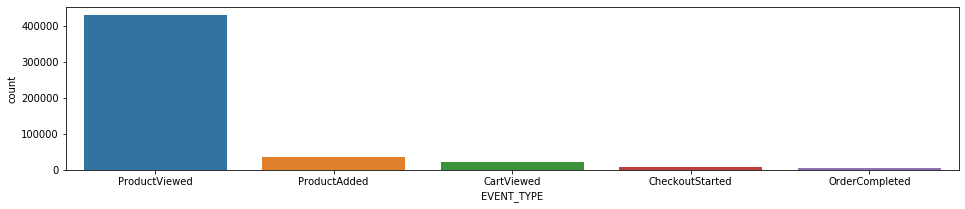

In [13]:
categorical_attributes = interactions_df.select_dtypes(include = ['object'])

plt.figure(figsize=(16,3))
sns.countplot(data = categorical_attributes, x = 'EVENT_TYPE')

#### Prepare and Upload Data

In [14]:
boto3.Session().resource('s3').Bucket(bucket).Object(interactions_filename).upload_file(interactions_filename)

## Configure Amazon Personalize

Now that we've prepared our three datasets and uploaded them to S3 we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations.

### Create Schemas for Datasets

Amazon Personalize requires a schema for each dataset so it can map the columns in our CSVs to fields for model training. Each schema is declared in JSON using the [Apache Avro](https://avro.apache.org/) format.

Let's define and create schemas in Personalize for our datasets.

#### Items Datsaset Schema

In [15]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "CATEGORY",
            "type": "string",
            "categorical": True,
        },
        {
            "name": "STYLE",
            "type": "string",
            "categorical": True,
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "retaildemostore-schema-items",
    schema = json.dumps(items_schema)
)

items_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:eu-west-1:554456892689:schema/retaildemostore-schema-items",
  "ResponseMetadata": {
    "RequestId": "1e865bac-95b9-4bad-876d-0b7589acb5d7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:10:24 GMT",
      "x-amzn-requestid": "1e865bac-95b9-4bad-876d-0b7589acb5d7",
      "content-length": "94",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Users Dataset Schema

In [16]:
users_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "AGE",
            "type": "int"
        },
        {
            "name": "GENDER",
            "type": "string",
            "categorical": True,
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "retaildemostore-schema-users",
    schema = json.dumps(users_schema)
)

users_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:eu-west-1:554456892689:schema/retaildemostore-schema-users",
  "ResponseMetadata": {
    "RequestId": "9367d63c-be92-448d-b5b4-edcd33329a88",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:11:18 GMT",
      "x-amzn-requestid": "9367d63c-be92-448d-b5b4-edcd33329a88",
      "content-length": "94",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Interactions Dataset Schema

In [17]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "retaildemostore-schema-interactions",
    schema = json.dumps(interactions_schema)
)

interactions_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:eu-west-1:554456892689:schema/retaildemostore-schema-interactions",
  "ResponseMetadata": {
    "RequestId": "c079e7da-280e-403c-a36d-051dc6b1dbce",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:11:51 GMT",
      "x-amzn-requestid": "c079e7da-280e-403c-a36d-051dc6b1dbce",
      "content-length": "101",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create and Wait for Dataset Group

Next we need to create the dataset group that will contain our three datasets.

#### Create Dataset Group

In [18]:
create_dataset_group_response = personalize.create_dataset_group(
    name = 'retaildemostore'
)
dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

print(f'DatasetGroupArn = {dataset_group_arn}')

{
  "datasetGroupArn": "arn:aws:personalize:eu-west-1:554456892689:dataset-group/retaildemostore",
  "ResponseMetadata": {
    "RequestId": "b1213fe9-7f7f-4f8b-9f7d-cc009a754280",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:12:15 GMT",
      "x-amzn-requestid": "b1213fe9-7f7f-4f8b-9f7d-cc009a754280",
      "content-length": "94",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
DatasetGroupArn = arn:aws:personalize:eu-west-1:554456892689:dataset-group/retaildemostore


#### Wait for Dataset Group to Have ACTIVE Status

In [19]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: ACTIVE


### Create Items Dataset

Next we will create the datasets in Personalize for our three dataset types. Let's start with the items dataset.

In [20]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "retaildemostore-dataset-items",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = items_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:eu-west-1:554456892689:dataset/retaildemostore/ITEMS",
  "ResponseMetadata": {
    "RequestId": "579500ad-6774-406c-8866-94cee26a5caa",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:16:15 GMT",
      "x-amzn-requestid": "579500ad-6774-406c-8866-94cee26a5caa",
      "content-length": "89",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create Users Dataset

In [21]:
dataset_type = "USERS"
create_dataset_response = personalize.create_dataset(
    name = "retaildemostore-dataset-users",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = users_schema_arn
)

users_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:eu-west-1:554456892689:dataset/retaildemostore/USERS",
  "ResponseMetadata": {
    "RequestId": "55c05b5e-fd4d-42b4-8b42-1d388b5228d4",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:16:31 GMT",
      "x-amzn-requestid": "55c05b5e-fd4d-42b4-8b42-1d388b5228d4",
      "content-length": "89",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create Interactions Dataset

In [22]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "retaildemostore-dataset-interactions",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interactions_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:eu-west-1:554456892689:dataset/retaildemostore/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "ed41e680-8609-4cc9-bf46-dcfb683770e0",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:16:39 GMT",
      "x-amzn-requestid": "ed41e680-8609-4cc9-bf46-dcfb683770e0",
      "content-length": "96",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Import Datasets to Personalize

Up to this point we have generated CSVs containing data for our users, items, and interactions and staged them in an S3 bucket. We also created schemas in Personalize that define the columns in our CSVs. Then we created a datset group and three datasets in Personalize that will receive our data. In the following steps we will create import jobs with Personalize that will import the datasets from our S3 bucket into the service.

### Setup Permissions

By default, the Personalize service does not have permission to acccess the data we uploaded into the S3 bucket in our account. In order to grant access to the  Personalize service to read our CSVs, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume.

#### Attach policy to S3 bucket

In [23]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy));

#### Create S3 Read Only Access Role

In [24]:
iam = boto3.client("iam")

role_name = Uid+"-PersonalizeS3"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
);

iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = "arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
);

role_arn = create_role_response["Role"]["Arn"]
print('IAM Role: {}'.format(role_arn))
# Pause to allow role to fully persist
time.sleep(10)

IAM Role: arn:aws:iam::554456892689:role/retaildemostore-eu-west-1-PersonalizeS3


### Create Import Jobs

With the permissions in place to allow Personalize to access our CSV files, let's create three import jobs to import each file into its respective dataset. Each import job can take several minutes to complete so we'll create all three and then wait for them all to complete.

#### Create Items Dataset Import Job

In [25]:
items_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "retaildemostore-dataset-items-import-job",
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, items_filename)
    },
    roleArn = role_arn
)

items_dataset_import_job_arn = items_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(items_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:eu-west-1:554456892689:dataset-import-job/retaildemostore-dataset-items-import-job",
  "ResponseMetadata": {
    "RequestId": "ac827f96-e249-4e85-8f15-80a5ed642043",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:19:18 GMT",
      "x-amzn-requestid": "ac827f96-e249-4e85-8f15-80a5ed642043",
      "content-length": "128",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Users Dataset Import Job

In [26]:
users_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "retaildemostore-dataset-users-import-job",
    datasetArn = users_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, users_filename)
    },
    roleArn = role_arn
)

users_dataset_import_job_arn = users_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(users_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:eu-west-1:554456892689:dataset-import-job/retaildemostore-dataset-users-import-job",
  "ResponseMetadata": {
    "RequestId": "a219a54d-e4ab-401a-a5ef-caf71aabcf35",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:19:33 GMT",
      "x-amzn-requestid": "a219a54d-e4ab-401a-a5ef-caf71aabcf35",
      "content-length": "128",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Interactions Dataset Import Job

In [27]:
interactions_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "retaildemostore-dataset-interactions-import-job",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, interactions_filename)
    },
    roleArn = role_arn
)

interactions_dataset_import_job_arn = interactions_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(interactions_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:eu-west-1:554456892689:dataset-import-job/retaildemostore-dataset-interactions-import-job",
  "ResponseMetadata": {
    "RequestId": "59673bc3-d150-424c-930c-b8ac60086e2b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:19:42 GMT",
      "x-amzn-requestid": "59673bc3-d150-424c-930c-b8ac60086e2b",
      "content-length": "135",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Wait for Import Jobs to Complete

It will take 10-15 minutes for the import jobs to complete, while you're waiting you can learn more about Datasets and Schemas here: https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html

We will wait for all three jobs to finish.

#### Wait for Items Import Job to Complete

In [28]:
%%time

import_job_arns = [ items_dataset_import_job_arn, users_dataset_import_job_arn, interactions_dataset_import_job_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for job_arn in reversed(import_job_arns):
        import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = job_arn
        )
        status = import_job_response["datasetImportJob"]['status']

        if status == "ACTIVE":
            print(f'Import job {job_arn} successfully completed')
            import_job_arns.remove(job_arn)
        elif status == "CREATE FAILED":
            print(f'Import job {job_arn} failed')
            if import_job_response.get('failureReason'):
                print('   Reason: ' + import_job_response['failureReason'])
            import_job_arns.remove(job_arn)

    if len(import_job_arns) > 0:
        print('At least one dataset import job still in progress')
        time.sleep(60)
    else:
        print("All import jobs have ended")
        break

Import job arn:aws:personalize:eu-west-1:554456892689:dataset-import-job/retaildemostore-dataset-interactions-import-job successfully completed
Import job arn:aws:personalize:eu-west-1:554456892689:dataset-import-job/retaildemostore-dataset-users-import-job successfully completed
Import job arn:aws:personalize:eu-west-1:554456892689:dataset-import-job/retaildemostore-dataset-items-import-job successfully completed
All import jobs have ended
CPU times: user 24.2 ms, sys: 7 µs, total: 24.2 ms
Wall time: 1.12 s


## Create Solutions

With our three datasets imported into our dataset group, we can now turn to training models. As a reminder, we will be training three models in this workshop to support three different personalization use-cases. One model will be used to make related product recommendations on the product detail view/page, another model will be used to make personalized product recommendations to users on the homepage, and the last model will be used to rerank product lists on the category and featured products page. In Amazon Personalize, training a model involves creating a Solution and Solution Version. So when we are finished we will have three solutions and a solution version for each solution. 

When creating a solution, you provide your dataset group and the recipe for training. Let's declare the recipes that we will need for our solutions.

### List Recipes

First, let's list all available recipes.

In [29]:
list_recipes_response = personalize.list_recipes()
list_recipes_response

{'recipes': [{'name': 'aws-hrnn',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 17, 13, 21, 939000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-coldstart',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-coldstart',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 17, 13, 21, 938000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-metadata',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-metadata',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 17, 13, 21, 938000, tzinfo=tzlocal())},
  {'name': 'aws-personalized-ranking',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-personalized-ranking',
  

As you can see above, there are several recipes to choose from. Let's declare the recipes for each Solution.

#### Declare Personalize Recipe for Related Products

On the product detail page we want to display related products so we'll create a campaign using the [SIMS](https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-sims.html) recipe.

> The Item-to-item similarities (SIMS) recipe is based on the concept of collaborative filtering. A SIMS model leverages user-item interaction data to recommend items similar to a given item. In the absence of sufficient user behavior data for an item, this recipe recommends popular items.

In [31]:
related_recipe_arn = "arn:aws:personalize:::recipe/aws-sims"

#### Declare Personalize Recipe for Product Recommendations

Since we are providing metadata for users and items, we will be using the [HRNN-Metadata](https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-hrnn-metadata.html) recipe for our product recommendations solution.

> The HRNN-Metadata recipe predicts the items that a user will interact with. It is similar to the HRNN recipe, with additional features derived from contextual, user, and item metadata (from Interactions, Users, and Items datasets, respectively). HRNN-Metadata provides accuracy benefits over non-metadata models when high quality metadata is available. Using this recipe might require longer training times.

In [32]:
recommend_recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn-metadata"

#### Declare Personalize Recipe for Personalized Ranking

In use-cases where we have a curated list of products, we can use the [Personalized-Ranking](https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-search.html) recipe to reorder the products for the current user.

> The Personalized-Ranking recipe generates personalized rankings. A personalized ranking is a list of recommended items that are re-ranked for a specific user.

In [33]:
ranking_recipe_arn = "arn:aws:personalize:::recipe/aws-personalized-ranking"

### Create Solutions and Solution Versions

With our recipes defined, we can now create our solutions and solution versions.

#### Create Related Products Solution

In [34]:
create_solution_response = personalize.create_solution(
    name = "retaildemostore-related-products",
    datasetGroupArn = dataset_group_arn,
    recipeArn = related_recipe_arn
)

related_solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-related-products",
  "ResponseMetadata": {
    "RequestId": "8d1dd5ae-8f40-4df3-ad88-a924eca043f6",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:51:52 GMT",
      "x-amzn-requestid": "8d1dd5ae-8f40-4df3-ad88-a924eca043f6",
      "content-length": "102",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Related Products Solution Version

In [35]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = related_solution_arn
)

related_solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-related-products/66321e4a",
  "ResponseMetadata": {
    "RequestId": "e43c935e-93c0-4af2-a69c-0462f96bd552",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:52:05 GMT",
      "x-amzn-requestid": "e43c935e-93c0-4af2-a69c-0462f96bd552",
      "content-length": "118",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Product Recommendation Solution

In [36]:
create_solution_response = personalize.create_solution(
    name = "retaildemostore-product-personalization",
    datasetGroupArn = dataset_group_arn,
    recipeArn = recommend_recipe_arn
)

recommend_solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-product-personalization",
  "ResponseMetadata": {
    "RequestId": "49ef0e5d-4b60-4da1-87f2-df2068926b93",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:52:11 GMT",
      "x-amzn-requestid": "49ef0e5d-4b60-4da1-87f2-df2068926b93",
      "content-length": "109",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Product Recommendation Solution Version

In [37]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = recommend_solution_arn
)

recommend_solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-product-personalization/ea66101f",
  "ResponseMetadata": {
    "RequestId": "81fa56fb-ae6d-4962-b8d3-cff95cd3699a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:52:19 GMT",
      "x-amzn-requestid": "81fa56fb-ae6d-4962-b8d3-cff95cd3699a",
      "content-length": "125",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Personalized Ranking Solution

In [38]:
create_solution_response = personalize.create_solution(
    name = "retaildemostore-personalized-ranking",
    datasetGroupArn = dataset_group_arn,
    recipeArn = ranking_recipe_arn
)

ranking_solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-personalized-ranking",
  "ResponseMetadata": {
    "RequestId": "20cce176-8ee3-42e5-95bf-0b443284908d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:52:27 GMT",
      "x-amzn-requestid": "20cce176-8ee3-42e5-95bf-0b443284908d",
      "content-length": "106",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Personalized Ranking Solution Version

In [39]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = ranking_solution_arn
)

ranking_solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-personalized-ranking/a2dfc89a",
  "ResponseMetadata": {
    "RequestId": "15d8d6cd-7346-4b5f-beab-aadffdb61131",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 14:52:33 GMT",
      "x-amzn-requestid": "15d8d6cd-7346-4b5f-beab-aadffdb61131",
      "content-length": "122",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Wait for Solution Versions to Complete

It can take 40-60 minutes for all solution versions to be created. During this process a model is being trained and tested with the data contained within your datasets. The duration of training jobs can increase based on the size of the dataset, training parameters and using AutoML vs. manually selecting a recipe. We submitted requests for all three solutions and versions at once so they are trained in parallel and then below we will wait for all three to finish.

While you are waiting for this process to complete you can learn more about solutions here: https://docs.aws.amazon.com/personalize/latest/dg/training-deploying-solutions.html

#### Wait for Related Products Solution Version to Have ACTIVE Status

In [40]:
%%time

soln_ver_arns = [ related_solution_version_arn, recommend_solution_version_arn, ranking_solution_version_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for soln_ver_arn in reversed(soln_ver_arns):
        soln_ver_response = personalize.describe_solution_version(
            solutionVersionArn = soln_ver_arn
        )
        status = soln_ver_response["solutionVersion"]["status"]

        if status == "ACTIVE":
            print(f'Solution version {soln_ver_arn} successfully completed')
            soln_ver_arns.remove(soln_ver_arn)
        elif status == "CREATE FAILED":
            print(f'Solution version {soln_ver_arn} failed')
            if soln_ver_response.get('failureReason'):
                print('   Reason: ' + soln_ver_response['failureReason'])
            soln_ver_arns.remove(soln_ver_arn)

    if len(soln_ver_arns) > 0:
        print('At least one solution version is still in progress')
        time.sleep(60)
    else:
        print("All solution versions have completed")
        break

Solution version arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-personalized-ranking/a2dfc89a successfully completed
Solution version arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-product-personalization/ea66101f successfully completed
Solution version arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-related-products/66321e4a successfully completed
All solution versions have completed
CPU times: user 24.2 ms, sys: 6 µs, total: 24.2 ms
Wall time: 1.12 s


### Evaluate Offline Metrics for Solution Versions

Amazon Personalize provides [offline metrics](https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html#working-with-training-metrics-metrics) that allow you to evaluate the performance of the solution version before you deploy the model in your application. Metrics can also be used to view the effects of modifying a Solution's hyperparameters or to compare the metrics between solutions that use the same training data but created with different recipes.

Let's retrieve the metrics for the solution versions we just created.

#### Related Products Metrics

In [41]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = related_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-related-products/66321e4a",
  "metrics": {
    "coverage": 1.0,
    "mean_reciprocal_rank_at_25": 0.6189,
    "normalized_discounted_cumulative_gain_at_10": 0.548,
    "normalized_discounted_cumulative_gain_at_25": 0.6422,
    "normalized_discounted_cumulative_gain_at_5": 0.4355,
    "precision_at_10": 0.2933,
    "precision_at_25": 0.1665,
    "precision_at_5": 0.3436
  },
  "ResponseMetadata": {
    "RequestId": "7ef06b5c-02ce-4628-bd1a-b97a8c05dc8e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 16:01:52 GMT",
      "x-amzn-requestid": "7ef06b5c-02ce-4628-bd1a-b97a8c05dc8e",
      "content-length": "412",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Product Recommendations Metrics

In [42]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = recommend_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-product-personalization/ea66101f",
  "metrics": {
    "coverage": 1.0,
    "mean_reciprocal_rank_at_25": 0.762,
    "normalized_discounted_cumulative_gain_at_10": 0.6742,
    "normalized_discounted_cumulative_gain_at_25": 0.7555,
    "normalized_discounted_cumulative_gain_at_5": 0.5782,
    "precision_at_10": 0.3848,
    "precision_at_25": 0.2005,
    "precision_at_5": 0.4982
  },
  "ResponseMetadata": {
    "RequestId": "509975a8-b56b-47bc-ad9e-6a812b733e0f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 16:03:33 GMT",
      "x-amzn-requestid": "509975a8-b56b-47bc-ad9e-6a812b733e0f",
      "content-length": "419",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Personalized Ranking Metrics

In [43]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = ranking_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:eu-west-1:554456892689:solution/retaildemostore-personalized-ranking/a2dfc89a",
  "metrics": {
    "coverage": 0.4386,
    "mean_reciprocal_rank_at_25": 0.7004,
    "normalized_discounted_cumulative_gain_at_10": 0.6997,
    "normalized_discounted_cumulative_gain_at_25": 0.7196,
    "normalized_discounted_cumulative_gain_at_5": 0.6091,
    "precision_at_10": 0.2623,
    "precision_at_25": 0.1149,
    "precision_at_5": 0.3622
  },
  "ResponseMetadata": {
    "RequestId": "088e1c2c-2703-4e1d-b967-4872103e7d0b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 16:04:31 GMT",
      "x-amzn-requestid": "088e1c2c-2703-4e1d-b967-4872103e7d0b",
      "content-length": "420",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Create Campaigns

Once we're satisfied with our solution versions, we need to create Campaigns for each solution version. When creating a campaign you specify the minimum transactions per second (`minProvisionedTPS`) that you expect to make against the service for this campaign. Personalize will automatically scale the inference endpoint up and down for the campaign to match demand but will never scale below `minProvisionedTPS`.

Let's create campaigns for our three solution versions with each set at `minProvisionedTPS` of 1.

#### Create Related Products Campaign

In [44]:
create_campaign_response = personalize.create_campaign(
    name = "retaildemostore-related-products",
    solutionVersionArn = related_solution_version_arn,
    minProvisionedTPS = 1
)

related_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:eu-west-1:554456892689:campaign/retaildemostore-related-products",
  "ResponseMetadata": {
    "RequestId": "3d7c51ed-4ee6-4bad-a003-8fe939924e5d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 16:07:52 GMT",
      "x-amzn-requestid": "3d7c51ed-4ee6-4bad-a003-8fe939924e5d",
      "content-length": "102",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Product Recommendation Campaign

In [45]:
create_campaign_response = personalize.create_campaign(
    name = "retaildemostore-product-personalization",
    solutionVersionArn = recommend_solution_version_arn,
    minProvisionedTPS = 1
)

recommend_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:eu-west-1:554456892689:campaign/retaildemostore-product-personalization",
  "ResponseMetadata": {
    "RequestId": "eadb0c10-6370-41cc-a60e-f6eed489f0ac",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 16:09:48 GMT",
      "x-amzn-requestid": "eadb0c10-6370-41cc-a60e-f6eed489f0ac",
      "content-length": "109",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Personalized Ranking Campaign

In [46]:
create_campaign_response = personalize.create_campaign(
    name = "retaildemostore-personalized-ranking",
    solutionVersionArn = ranking_solution_version_arn,
    minProvisionedTPS = 1
)

ranking_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:eu-west-1:554456892689:campaign/retaildemostore-personalized-ranking",
  "ResponseMetadata": {
    "RequestId": "9d7dbd17-6237-4c25-8bb8-8d22a870423a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Sep 2020 16:10:41 GMT",
      "x-amzn-requestid": "9d7dbd17-6237-4c25-8bb8-8d22a870423a",
      "content-length": "106",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Wait for Related Products Campaign to Have ACTIVE Status

It can take 20-30 minutes for the campaigns to be fully created. 

While you are waiting for this to complete you can learn more about campaigns here: https://docs.aws.amazon.com/personalize/latest/dg/campaigns.html

In [47]:
%%time

campaign_arns = [ related_campaign_arn, recommend_campaign_arn, ranking_campaign_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for campaign_arn in reversed(campaign_arns):
        campaign_response = personalize.describe_campaign(
            campaignArn = campaign_arn
        )
        status = campaign_response["campaign"]["status"]

        if status == "ACTIVE":
            print(f'Campaign {campaign_arn} successfully completed')
            campaign_arns.remove(campaign_arn)
        elif status == "CREATE FAILED":
            print(f'Campaign {campaign_arn} failed')
            if campaign_response.get('failureReason'):
                print('   Reason: ' + campaign_response['failureReason'])
            campaign_arns.remove(campaign_arn)

    if len(campaign_arns) > 0:
        print('At least one campaign is still in progress')
        time.sleep(60)
    else:
        print("All campaigns have completed")
        break

Campaign arn:aws:personalize:eu-west-1:554456892689:campaign/retaildemostore-personalized-ranking successfully completed
Campaign arn:aws:personalize:eu-west-1:554456892689:campaign/retaildemostore-product-personalization successfully completed
Campaign arn:aws:personalize:eu-west-1:554456892689:campaign/retaildemostore-related-products successfully completed
All campaigns have completed
CPU times: user 21.3 ms, sys: 2 µs, total: 21.3 ms
Wall time: 133 ms


## Test Campaigns

Now that our campaigns have been fully created, let's test each campaign and evaluate the results.

### Test Related Product Recommendations Campaign

Let's test the recommendations made by the related items/products campaign by selecting a product from the Retail Demo Store's [Products](https://github.com/aws-samples/retail-demo-store/tree/master/src/products) microservice and requesting related item recommendations for that product.

#### Select a Product

We'll just pick a random product for simplicity. Feel free to change the `product_id` below and execute the following cells with a different product to get a sense for how the recommendations change.

In [50]:
product_id = 37

response = requests.get('http://{}/products/id/{}'.format(products_service_instance, product_id))
product = response.json()
print(json.dumps(product, indent=4, sort_keys=True))

{
    "category": "footwear",
    "description": "Whether on deck or on the town, these blue deck shoes with brown leather accents will draw a salute.",
    "id": "37",
    "image": "5.jpg",
    "name": "Sporty Deck Shoe",
    "price": 129.99,
    "sk": "",
    "style": "sneaker",
    "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/37"
}


#### Get Related Product Recommendations for Product

Now let's call Amazon Personalize to get related item/product recommendations for our product from the related item campaign.

In [51]:
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = related_campaign_arn,
    itemId = str(product_id),
    numResults = 10
)

item_list = get_recommendations_response['itemList']

In [52]:
print(json.dumps(item_list, indent=4))

[
    {
        "itemId": "49"
    },
    {
        "itemId": "45"
    },
    {
        "itemId": "56"
    },
    {
        "itemId": "8"
    },
    {
        "itemId": "40"
    },
    {
        "itemId": "24"
    },
    {
        "itemId": "32"
    },
    {
        "itemId": "48"
    },
    {
        "itemId": "16"
    },
    {
        "itemId": "5"
    }
]


Since the `itemId`'s in the above response don't tell us much about the products being recommended, let's get detailed information for each item ID from the Products microservice.

In [53]:
for item in item_list:
    response = requests.get('http://{}/products/id/{}'.format(products_service_instance, item['itemId']))
    print(json.dumps(response.json(), indent = 4))

{
    "id": "49",
    "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/49",
    "sk": "",
    "name": "Light Brown Leather Lace-Up Boot",
    "category": "footwear",
    "style": "boot",
    "description": "Sturdy enough for the outdoors yet stylish to wear out on the town.",
    "price": 89.95,
    "image": "11.jpg"
}
{
    "id": "45",
    "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/45",
    "sk": "",
    "name": "Classic Black Leather Hi-Tops",
    "category": "footwear",
    "style": "sneaker",
    "description": "Casual or dressy, this black leather hi-top has you covered.",
    "price": 129.99,
    "image": "6.jpg"
}
{
    "id": "56",
    "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/56",
    "sk": "",
    "name": "Red Fishing Lure",
    "category": "outdoors",
    "style": "fishing",
    "description": "Every tackle box needs a silver and red reflective fishing lure.",
    "price": 9.99,
    "image": "12.jpg"
}
{
    "id": "8",
    "url": "http://d2syr0q

Based on the random product selected above, do the similar item recommendations from Personalize make sense? Keep in mind that the similar item recommendations from the SIMS recipe are based on the interactions we generated as input into the solution creation process above.

### Test Product Recommendations Campaign

Let's test the recommendations made by the product recommendations campaign by selecting a user from the Retail Demo Store's Users microservice and requesting item recommendations for that user.

#### Select a User

We'll just pick a random user for simplicity. Feel free to change the `user_id` below and execute the following cells with a different user to get a sense for how the recommendations change.

In [54]:
user_id = 256

response = requests.get('http://{}/users/id/{}'.format(users_service_instance, user_id))
user = response.json()
persona = user['persona']

In [55]:
print(json.dumps(user, indent=4, sort_keys=True))

{
    "addresses": [
        {
            "address1": "2058 Alison Locks Apt. 412",
            "address2": "",
            "city": "Shellyview",
            "country": "US",
            "default": true,
            "first_name": "Tiffany",
            "last_name": "Mcclure",
            "state": "TN",
            "zipcode": "37097"
        }
    ],
    "age": 41,
    "email": "tiffany.mcclure@example.com",
    "first_name": "Tiffany",
    "gender": "F",
    "id": "256",
    "last_name": "Mcclure",
    "persona": "accessories_jewelry_apparel",
    "username": "user256"
}


**Take note of the `persona` value for the user above. We should see recommendations for products consistent with this persona since we generated historical interactions for products in the categories represented in the persona.**

In [56]:
print('Shopper persona for user {} is {}'.format(user_id, persona))

Shopper persona for user 256 is accessories_jewelry_apparel


#### Get Product Recommendations for User

Now let's call Amazon Personalize to get recommendations for our user from the product recommendations campaign.

In [57]:
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = recommend_campaign_arn,
    userId = str(user_id),
    numResults = 10
)

item_list = get_recommendations_response['itemList']

In [58]:
print(json.dumps(item_list, indent=4))

[
    {
        "itemId": "55",
        "score": 0.090827
    },
    {
        "itemId": "41",
        "score": 0.0877652
    },
    {
        "itemId": "17",
        "score": 0.0801789
    },
    {
        "itemId": "9",
        "score": 0.0794353
    },
    {
        "itemId": "47",
        "score": 0.0743058
    },
    {
        "itemId": "25",
        "score": 0.0718515
    },
    {
        "itemId": "7",
        "score": 0.0689271
    },
    {
        "itemId": "33",
        "score": 0.063773
    },
    {
        "itemId": "42",
        "score": 0.0551505
    },
    {
        "itemId": "1",
        "score": 0.0521234
    }
]


Notice that in this response we have a new `score` field returned with each `itemId`. For all recipes except SIMS and Popularity-Count, Personalize [calculates a score](https://docs.aws.amazon.com/personalize/latest/dg/getting-real-time-recommendations.html) for each recommended item **across all items in your dataset**. Score values are between 0.0 and 1.0 and the sum of all scores across all items will total to 1.0. Therefore, the absolute value of scores will be smaller for larger item catalogs. 

Since the `itemId`'s in the above response don't tell us much about the products being recommended, let's retrieve product details from the Products microservice.

In [59]:
print('User persona: ' + persona)

for item in item_list:
    response = requests.get('http://{}/products/id/{}'.format(products_service_instance, item['itemId']))
    print(json.dumps(response.json(), indent = 4))

User persona: accessories_jewelry_apparel
{
    "id": "55",
    "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/55",
    "sk": "",
    "name": "Pink Leather Purse",
    "category": "accessories",
    "style": "bag",
    "description": "Conveniently sized to carry all your essentials in style, pink tassle included.",
    "price": 89.99,
    "image": "9.jpg",
    "gender_affinity": "F"
}
{
    "id": "41",
    "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/41",
    "sk": "",
    "name": "Tan Leather Shoulder Bag",
    "category": "accessories",
    "style": "bag",
    "description": "Clean and simple styling.",
    "price": 109.99,
    "image": "6.jpg",
    "gender_affinity": "F"
}
{
    "id": "17",
    "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/17",
    "sk": "",
    "name": "Black Women's Purse",
    "category": "accessories",
    "style": "bag",
    "description": "Spacious and stylish in a single bag.",
    "price": 109.99,
    "image": "3.jpg",
    "gender_

Are the recommended products consistent with the persona? Note that this is a rather contrived example using a limited amount of generated interaction data without model parameter tuning. The purpose is to give you hands on experience building models and retrieving inferences from Amazon Personalize. 

### Test Personalized Ranking Campaign

Next let's evaluate the results of the personalized ranking campaign. As a reminder, given a list of items and a user, this campaign will rerank the items based on the preferences of the user. For the Retail Demo Store, we will use this campaign to rerank the products listed for each category and the featured products list as well as reranking catalog search results displayed in the search widget.

#### Get Featured Products List

First let's get the list of featured products from the Products microservice.

In [61]:
response = requests.get('http://{}/products/featured'.format(products_service_instance))
featured_products = response.json()
print(json.dumps(featured_products, indent = 4))

[
    {
        "id": "36",
        "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/36",
        "sk": "",
        "name": "Exercise Headphones",
        "category": "electronics",
        "style": "headphones",
        "description": "These stylishly red ear buds wrap securely around your ears making them perfect when exercising or on the go.",
        "price": 19.99,
        "image": "5.jpg",
        "featured": "true"
    },
    {
        "id": "2",
        "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/2",
        "sk": "",
        "name": "Striped Shirt",
        "category": "apparel",
        "style": "shirt",
        "description": "A classic look for the summer season.",
        "price": 9.99,
        "image": "1.jpg",
        "featured": "true",
        "gender_affinity": "F"
    },
    {
        "id": "48",
        "url": "http://d2syr0qoho6cqh.cloudfront.net/#/product/48",
        "sk": "",
        "name": "Silver Fishing Lure",
        "category": "outdoors",

#### ReRank Featured Products

Using the featured products list just retrieved, first we'll create a list of item IDs that we want to rerank for a specific user. This reranking will allow us to provide ranked products based on the user's behavior. These behaviors should be consistent the same persona that was mentioned above (since we're going to use the same `user_id`).

In [62]:
unranked_product_ids = []

for product in featured_products:
    unranked_product_ids.append(product['id'])
    
print(unranked_product_ids)

['36', '2', '48', '1', '6', '52', '27', '5', '4', '51', '26', '3', '25', '15']


Now let's have Personalize rank the featured product IDs based on our random user.

In [63]:
response = personalize_runtime.get_personalized_ranking(
    campaignArn=ranking_campaign_arn,
    inputList=unranked_product_ids,
    userId=str(user_id)
)
print(json.dumps(response['personalizedRanking'], indent = 4))

[
    {
        "itemId": "52",
        "score": 0.3763555
    },
    {
        "itemId": "1",
        "score": 0.2858394
    },
    {
        "itemId": "25",
        "score": 0.2075236
    },
    {
        "itemId": "2",
        "score": 0.1230665
    },
    {
        "itemId": "27",
        "score": 0.002173
    },
    {
        "itemId": "26",
        "score": 0.0016944
    },
    {
        "itemId": "51",
        "score": 0.0012516
    },
    {
        "itemId": "6",
        "score": 0.0009463
    },
    {
        "itemId": "36",
        "score": 0.0004247
    },
    {
        "itemId": "4",
        "score": 0.000362
    },
    {
        "itemId": "15",
        "score": 0.0002605
    },
    {
        "itemId": "48",
        "score": 7.86e-05
    },
    {
        "itemId": "5",
        "score": 1.58e-05
    },
    {
        "itemId": "3",
        "score": 7.9e-06
    }
]


Are the reranked results different than the original results from the Search service? Notice that we are also given a score that indicates the recommended ranking across all items in the catalog. Experiment with a different `user_id` in the cells above to see how the item ranking changes.

## Enable Campaigns in Retail Demo Store Recommendations Service

Now that we've tested our campaigns and can get related product, product recommendations, and reranked items for our users, we need to enable the campaigns in the Retail Demo Store's [Recommendations service](https://github.com/aws-samples/retail-demo-store/tree/master/src/recommendations). The Recommendations service is called by the Retail Demo Store Web UI when a signed in user visits a page with personalized content capabilities (home page, product detail page, and category page). The Recommendations service checks Systems Manager Parameters values to determine the Personalize campaign ARNs to use for each of our three personalization use-cases.

Let's set the campaign ARNs for our campaigns in the expected parameter names.

### Update SSM Parameter To Enable Related Products

In [64]:
response = ssm.put_parameter(
    Name='retaildemostore-related-products-campaign-arn',
    Description='Retail Demo Store Related Products Campaign Arn Parameter',
    Value='{}'.format(related_campaign_arn),
    Type='String',
    Overwrite=True
)

### Update SSM Parameter To Enable Product Recommendations

In [65]:
response = ssm.put_parameter(
    Name='retaildemostore-product-recommendation-campaign-arn',
    Description='Retail Demo Store Product Recommendation Campaign Arn Parameter',
    Value='{}'.format(recommend_campaign_arn),
    Type='String',
    Overwrite=True
)

### Update SSM Parameter To Enable Search Personalization

In [66]:
response = ssm.put_parameter(
    Name='retaildemostore-personalized-ranking-campaign-arn',
    Description='Retail Demo Store Personalized Ranking Campaign Arn Parameter',
    Value='{}'.format(ranking_campaign_arn),
    Type='String',
    Overwrite=True
)

## Evaluate Personalization in Retail Demo Store's Web UI

Now that you've enabled each personalization feature by setting the respective campaign ARN, you can test these personalization features through the Web App UI. If you haven't already opened a browser window/tab to the Retail Demo Store Web UI, navigate to the CloudFormation console in this AWS account and check the Outputs section of the stack used to launch the Retail Demo Store. Make sure you're checking the base stack and not the nested stacks that were created. In the Outputs section look for the output named: WebURL and browse to the URL provided.

![CloudFormation Outputs](../images/cfn-webui-outputs.png)

If you haven't already created a user account in your Retail Demo Store instance, let's create one now. Once you've accessed the Retail Demo Store Web UI, you can logon and create a new account. Click on the Sign In button and then the "**No account? Create account**" link to create an account. Follow the prompts and enter the required data. You will need to provide a valid mobile phone number in order to receive an SMS message with the confirmation code to validate your account.

Once you've created and validated your account, click on the Sign In button again and sign in with the account you created.

### Emulate Shopper

To confirm product recommendations are personalized, you can emulate a different user. Click on your username in the top right-corner and then select [**Profile**](https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/authenticated/Profile.vue). Use the Switch User drop-down to select a different user. In the drop down you will see a user's First and Last Name and a Persona that matches that user's behavior. Product recommendations should match the persona of the user you've selected.

![Emulate Shopper](../images/retaildemostore-emulate.png)

### Viewing Related Product Recommendations

Let's start with the Related Product Recommendations use-case. This campaign for this use-case is based on the [SIMS](https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-sims.html) recipe which uses item-to-item collaborative filtering at its core to derive an understanding of how users interact with similar items.

Browse to a [product detail page](https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/public/ProductDetail.vue) and evaluate the products listed in the **What other items do customers view related to this product?** section. You should see the recipe name displayed below the section header. This tells you that results are actually coming from the related item campaign. If you don't see the recipe name, the page is using default behavior of displaying products from the same category (verify that the campaign was created successfully above **and** the campaign ARN is set as an SSM parameter).

Given the shopper personas we used to generate historical data, do the related item recommendations make sense? For example, given that one of the shopper personas used across many of the customers is "footwear_outdoors", you should see related products from both of these categories when viewing a product from either category. Although this is a somewhat contrived example, it does illustrate how Personalize understands an affinity for products across these categories.

![Related Product Recommendations](./images/retaildemostore-related-products.png)

### Viewing Product Recommendations

With the user emulation saved, browse to the Retail Demo Store [home page](https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/public/Main.vue) and evaluate the products listed in the **Inspired by your shopping trends** section (towards bottom of page). Do they appear consistent with the shopping persona you're emulating? For the screenshots listed here, the user was trained with historical data based on the "footwear_outdoors" persona so we should see product recommendations from the Footwear and Outdoors categories.

![Personalized Product Recommendations](./images/retaildemostore-product-recs.png)

Note that if the section is titled **Featured** or you don't see the Personalize recipe name displayed, this indicates that either you are not signed in as a user or the campaign ARN is not set as the appropriate SSM parameter. Double check that the campaign was created successfully above and that the campaign ARN is set in SSM.

### Personalized Ranking

Finally, let's evaluate the personalizated ranking use-case. There are two places where personalized ranking is implemented in the Retail Demo Store. With a user emulated, browse to the featured product category list by clicking on "Featured" from the Retail Demo Store home page. Note how for the emulated user with a persona of "footwear_outdoors" that the shoe is moved to the first product. (See [CategoryDetail.vue](https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/public/CategoryDetail.vue)).

![Personalized Product Ranking](./images/retaildemostore-personalized-ranking.png)

The other feature where personalized ranking is implemented is in [search results](https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/public/Search.vue). Start typing a word in the search box and a search result widget will be displayed. If the results were reranked by Personalize, you will see a "Personalize Ranking" annotation in the search box. For the emulated user with a historical affinity for footwear and outdoors, notice that a search for product keywords starting with "s" will move shoes to the top of the results. 

![Personalized Search Results](./images/retaildemostore-personalized-search.png)

If the search functionality is not working at all for you, make sure that you completed the [Search workshop](../0-StartHere/Search.ipynb).

## Event Tracking - Keeping up with evolving user intent

Up to this point we have trained and deployed three Amazon Personalize campaigns based on historical data that we generated in this workshop. This allows us to make related product, user recommendations, and rerank product lists based on already observed behavior of our users. However, user intent often changes in real-time such that what products the user is interested in now may be different than what they were interested in a week ago, a day ago, or even a few minutes ago. Making recommendations that keep up with evolving user intent is one of the more difficult challenges with personalization. Fortunately, Amazon Personalize has a mechanism for this exact issue.

Amazon Personalize supports the ability to send real-time user events (i.e. clickstream) data into the service. Personalize uses this event data to improve recommendations. It will also save these events and automatically include them when solutions for the same dataset group are re-created (i.e. model retraining).

The Retail Demo Store's Web UI already has [logic to send events](https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/analytics/AnalyticsHandler.js) such as 'ProductViewed', 'ProductAdded', 'OrderCompleted', and others as they occur in real-time to a Personalize Event Tracker. These are the same event types we used to initially create the solutions and campaigns for our three use-cases. All we need to do is create an event tracker in Personalize, set the tracking Id for the tracker in an SSM parameter, and rebuild the Web UI service to pick up the change.

### Create Personalize Event Tracker

Let's start by creating an event tracker for our dataset group.

In [67]:
event_tracker_response = personalize.create_event_tracker(
    datasetGroupArn=dataset_group_arn,
    name='retaildemostore-event-tracker'
)

event_tracker_arn = event_tracker_response['eventTrackerArn']
event_tracking_id = event_tracker_response['trackingId']

print('Event Tracker ARN: ' + event_tracker_arn)
print('Event Tracking ID: ' + event_tracking_id)

Event Tracker ARN: arn:aws:personalize:eu-west-1:554456892689:event-tracker/8eaca4f4
Event Tracking ID: 5fb63f69-430a-40cd-ac4f-22633afc309b


### Wait for Event Tracker Status to Become ACTIVE

The event tracker should take a minute or so to become active.

In [68]:
status = None
max_time = time.time() + 60*60 # 1 hours
while time.time() < max_time:
    describe_event_tracker_response = personalize.describe_event_tracker(
        eventTrackerArn = event_tracker_arn
    )
    status = describe_event_tracker_response["eventTracker"]["status"]
    print("EventTracker: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

EventTracker: ACTIVE


### Update SSM Parameter To Enable Event Tracking

The Retail Demo Store's Web UI service just needs a Personalize Event Tracking Id to be able to send events to Personalize. The CodeBuild configuration for the Web UI service will pull the event tracking ID from an SSM parameter. 

Let's set our tracking ID in an SSM parameter.

In [69]:
response = ssm.put_parameter(
    Name='retaildemostore-personalize-event-tracker-id',
    Description='Retail Demo Store Personalize Event Tracker ID Parameter',
    Value='{}'.format(event_tracking_id),
    Type='String',
    Overwrite=True
)

### Trigger Web UI Service Release

Next let's trigger a new release of the Retail Demo Store's Web UI service so that it will pick up our SSM parameter change.

In the AWS console, browse to the AWS Code Pipeline service. Find the pipeline with **WebUIPipeline** in the name. Click on the pipeline name.

![AWS CodePipeline](./images/retaildemostore-codepipeline.png)

#### Trigger Release

To manually trigger a new release, click the **Release change** button, click the **Release** button on the popup dialog window, and then wait for the pipeline to build and deploy. This will rebuild the web app, deploy it to the web UI S3 bucket, and invalidate the CloudFront distribution to force browsers to load from the origin rather than from their local cache.

![AWS CodePipeline Release](./images/retaildemostore-codepipeline-release.png)

### Verify Event Tracking

Return to your web browser tab/window where the Retail Demo Store Web UI is loaded and **reload the web app/page**. Reloading the page is important so that the web app is reloaded in your browser and the new event tracking configuration is loaded as well.

There are a couple ways to verify that events are being sent to the Event Tracker. First, you can use your browser's developer tools to monitor the network calls made by the Retail Demo Store Web UI when you're browsing to product detail pages, adding items to carts, and completing orders. The other way you can verify that events are being received by the event tracker is in CloudWatch metrics for Personalize.

1. If you have done so, **reload the web app by refreshing/reloading your browser page.**
2. If not already signed in as a storefront user, sign in as (or create) a user. 
3. In the Retail Demo Store Web app, view product detail pages, add items to your cart, complete an order.
4. Verify that the Web UI is making "events" calls to the Personalize Event Tracker.
5. In the AWS console, browse to CloudWatch and then Metrics.

![Personalize CloudWatch Metrics](./images/retaildemostore-eventtracker-cw.png)

If events are not being sent to the event tracker, make sure that the WebUIPipeline pipeline was built and deployed successfully and that you reloaded the web app in your browser.

To assess the impact of real-time event tracking in recommendations made by the user recommendations on the home page, follow these steps.

1. Sign in as (or create) a storefront user.
2. View the product recommendations displayed on the home page under the "Inspired by your shopping trends" header. Take note of the products being recommended.
3. View products from categories that are not being recommended by clicking on their "Details" button. When you view the details for a product, an event is fired and sent to the Personalize event tracker.
4. Return to the home page and you should see products being recommended that are the same or similar to the ones you just viewed.

## Create Purchased Products Filter

Amazon Personalize supports the ability to create [filters](https://docs.aws.amazon.com/personalize/latest/dg/filter.html) that can be used to exclude items from being recommended that meet a filter expression. Since it's a poor user experience to recommend products that a user has already purchased, we will create a filter that excludes recently purchased products. We'll do this by creating a filter expression that excludes items that have an interaction with an event type of `OrderCompleted` for the user.

> As noted above, the Retail Demo Store web application streams clickstream events to Personalize when the user performs various actions such as viewing and purchasing products. The filter created below allows us to use those events as exclusion criteria. See the [AnalyticsHandler.js](https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/analytics/AnalyticsHandler.js) file for the code that sends clickstream events.

In [70]:
response = personalize.create_filter(
    name = 'retaildemostore-filter-purchased-products',
    datasetGroupArn = dataset_group_arn,
    filterExpression = 'EXCLUDE itemId WHERE INTERACTIONS.event_type in ("OrderCompleted")'
)
 
filter_arn = response['filterArn']
print(f'Filter ARN: {filter_arn}')

Filter ARN: arn:aws:personalize:eu-west-1:554456892689:filter/retaildemostore-filter-purchased-products


### Wait for Filter Status to Become ACTIVE

The filter should take a minute or so to become active.

In [71]:
status = None
max_time = time.time() + 60*60 # 1 hours
while time.time() < max_time:
    describe_filter_response = personalize.describe_filter(
        filterArn = filter_arn
    )
    status = describe_filter_response["filter"]["status"]
    print("Filter: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

Filter: CREATE PENDING
Filter: CREATE IN_PROGRESS
Filter: CREATE IN_PROGRESS
Filter: ACTIVE


### Test Purchased Products Filter

To test our purchased products filter, we will request recommendations for a random user. Then we will send an `OrderCompleted` event for one of the recommended products to Personalize using the event tracker created above. Finally, we will request recommendations again for the same user but this time specify our filter.

In [72]:
# Pick a user ID in the range of test users and fetch 5 recommendations.
user_id = '456'
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = recommend_campaign_arn,
    userId = user_id,
    numResults = 5
)

item_list = get_recommendations_response['itemList']
print(json.dumps(item_list, indent=2))

[
  {
    "itemId": "49",
    "score": 0.1143751
  },
  {
    "itemId": "48",
    "score": 0.0935527
  },
  {
    "itemId": "40",
    "score": 0.0857733
  },
  {
    "itemId": "8",
    "score": 0.0830365
  },
  {
    "itemId": "32",
    "score": 0.0713647
  }
]


Next let's randomly select an item from the returned list of recommendations to be our product to purchase.

In [73]:
product_id_to_purchase = item_list[randint(0, len(item_list)-1)]['itemId']
print(f'Product ID to purchase: {product_id_to_purchase}')

Product ID to purchase: 8


Next let's send an `OrderCompleted` event to Personalize to simulate that the product was just purchased. This will match the criteria for our filter. In the Retail Demo Store web application, this event is sent for each product in the order after the order is completed.

In [74]:
response = personalize_events.put_events(
    trackingId = event_tracking_id,
    userId = user_id,
    sessionId = str(uuid.uuid4()),
    eventList = [
        {
            'eventId': str(uuid.uuid4()),
            'eventType': 'OrderCompleted',
            'itemId': str(product_id_to_purchase),
            'sentAt': int(time.time())
        }
    ]
)

# Wait for OrderCompleted event to become consistent.
time.sleep(5)

print(json.dumps(response, indent=2))

{
  "ResponseMetadata": {
    "RequestId": "32423ab5-e0bb-4264-ab7a-54d22b6678c2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/json",
      "date": "Sun, 13 Sep 2020 04:39:15 GMT",
      "x-amzn-requestid": "32423ab5-e0bb-4264-ab7a-54d22b6678c2",
      "content-length": "0",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


Finally, let's retrieve recommendations for the user again but this time specifying the filter to exclude recently purchased items. We do this by passing the filter's ARN via the `filterArn` parameter. In the Retail Demo Store, this is done in the [Recommendations](https://github.com/aws-samples/retail-demo-store/tree/master/src/recommendations) service.

In [75]:
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = recommend_campaign_arn,
    userId = user_id,
    numResults = 5,
    filterArn = filter_arn
)

item_list = get_recommendations_response['itemList']
print(json.dumps(item_list, indent=2))

[
  {
    "itemId": "49",
    "score": 0.1396802
  },
  {
    "itemId": "48",
    "score": 0.0816641
  },
  {
    "itemId": "56",
    "score": 0.0778758
  },
  {
    "itemId": "16",
    "score": 0.0761338
  },
  {
    "itemId": "45",
    "score": 0.0757087
  }
]


The following code will raise an assertion error if the product we just purchased is still recommended.

In [76]:
found_item = next((item for item in item_list if item['itemId'] == product_id_to_purchase), None)
if found_item:
    assert found_item == False, 'Purchased item found unexpectedly in recommendations'
else:
    print('Purchased item filtered from recommendations for user!')

Purchased item filtered from recommendations for user!


### Update Filter SSM Parameter

With our filter created and tested, the last step is to update the SSM parameter that is used throughout the Retail Demo Store project to detect the filter ARN.

The [Recommendations](https://github.com/aws-samples/retail-demo-store/tree/master/src/recommendations) service already has logic to look for the purchased products filter ARN in SSM and use it when fetching recommendations. All we have to do is set the filter's ARN in SSM.

In [77]:
response = ssm.put_parameter(
    Name='retaildemostore-personalize-filter-purchased-arn',
    Description='Retail Demo Store Personalize Filter Purchased Products Arn Parameter',
    Value='{}'.format(filter_arn),
    Type='String',
    Overwrite=True
)

Now if you test completing an order for one or more items in the Retail Demo Store web application for a user, those products should no longer be included in recommendations for that user. Test it out by purchasing a recommended product from the "Inspired by your shopping trends" section of the home page and then verifying that the product is no longer recommended.

## Workshop Complete

Congratulations! You have completed the Retail Demo Store Personalization Workshop.

### Cleanup

If you launched the Retail Demo Store in your personal AWS account **AND** you're done with all workshops, you can follow the [Personalize workshop cleanup](./1.2-Personalize-Cleanup.ipynb) notebook to delete all of the Amazon Personalize resources created by this workshop. **IMPORTANT: since the Personalize resources were created by this notebook and not CloudFormation, deleting the CloudFormation stack for the Retail Demo Store will not remove the Personalize resources. You MUST run the [Personalize workshop cleanup](./1.2-Personalize-Cleanup.ipynb) notebook or manually clean up these resources.**

If you are participating in an AWS managed event such as a workshop and using an AWS provided temporary account, you can skip the cleanup workshop unless otherwise instructed.